In [79]:
# ============================================================
# ОБЪЕДИНЁННЫЙ ПАРСЕР MGS:  ODF + LBL + TDF (RAMP)
# ============================================================

import os
import re
import pandas as pd
import numpy as np
import struct
from datetime import datetime, timedelta
from pathlib import Path
from typing import List, Optional, Tuple
from dataclasses import dataclass


# ============================================================
# ЧАСТЬ 1: TDF PARSER (RAMP данные)
# ============================================================

@dataclass
class TDFRampRecord:
    """Запись RAMP из TDF файла"""
    timestamp: datetime
    station_id: int
    ramp_controller:  int
    ramp_rate:  float
    ramp_start_freq: float
    transmitter_freq: float
    uplink_band: int
    spacecraft_id: int


class TDFParser:
    """Парсер для TDF файлов — извлечение RAMP данных"""
    
    RECORD_SIZE = 288
    DATA_TYPE_RAMP = 6
    
    def __init__(self, verbose=True):
        self.verbose = verbose
        self.records = []
        
    def parse(self, filepath: str) -> pd.DataFrame:
        """Парсит TDF файл"""
        filepath = Path(filepath)
        
        if not filepath.exists():
            if self.verbose:
                print(f" Файл не найден: {filepath}")
            return pd.DataFrame()
        
        filesize = os.path.getsize(filepath)
        num_records = filesize // self. RECORD_SIZE
        
        if self. verbose:
            print(f"    TDF:  {filepath. name} ({num_records: ,} records)")
        
        self.records = []
        
        with open(filepath, 'rb') as f:
            for _ in range(num_records):
                data = f.read(self.RECORD_SIZE)
                if len(data) < self.RECORD_SIZE:
                    break
                record = self._parse_record(data)
                if record:
                    self.records.append(record)
        
        if self. verbose:
            print(f"      ✅ RAMP записей:  {len(self. records)}")
        
        return self._to_dataframe()
    
    def _parse_record(self, data: bytes) -> Optional[TDFRampRecord]:
        """Парсит одну запись TDF"""
        record_type = struct.unpack('>I', data[5:9])[0]
        if record_type not in (90, 91):
            return None
        
        dtb1 = struct.unpack('>I', data[18:22])[0]
        data_type = (dtb1 >> 8) & 0x3F
        
        if data_type != self.DATA_TYPE_RAMP: 
            return None
        
        timestamp = self._parse_datetime(data[9:18])
        if timestamp is None:
            return None
        
        station_id = (dtb1 >> 22) & 0x3FF
        spacecraft_id = struct.unpack('>H', data[22:24])[0]
        uplink_band = data[180]
        
        # RAMP данные
        ramp_controller = data[225]
        ramp_rate_hp = struct.unpack('>i', data[226:230])[0]
        ramp_rate_lp = struct.unpack('>i', data[230:234])[0]
        ramp_rate = ramp_rate_hp * 1e3 + ramp_rate_lp * 1e-6
        
        val = int.from_bytes(data[234:239], 'big')
        ramp_start_hp = (val >> 4) & 0xFFFFFFFF
        val2 = int.from_bytes(data[238:243], 'big')
        ramp_start_lp = (val2 >> 4) & 0xFFFFFFFF
        ramp_start_freq = ramp_start_hp * 1e3 + ramp_start_lp * 1e-6
        
        change_block = data[243:252]
        val = int.from_bytes(change_block, 'big')
        tx_hp = (val >> 30) & 0x0FFFFFFF
        tx_lp = val & 0x3FFFFFFF
        transmitter_freq = tx_hp * 1e3 + tx_lp * 1e-6
        
        return TDFRampRecord(
            timestamp=timestamp,
            station_id=station_id,
            ramp_controller=ramp_controller,
            ramp_rate=ramp_rate,
            ramp_start_freq=ramp_start_freq,
            transmitter_freq=transmitter_freq,
            uplink_band=uplink_band,
            spacecraft_id=spacecraft_id
        )
    
    def _parse_datetime(self, data:  bytes) -> Optional[datetime]:
        val = int.from_bytes(data[0:7], 'big')
        year_mod = (val >> 44) & 0xFFF
        doy = (val >> 28) & 0xFFFF
        hour = (val >> 20) & 0xFF
        minute = (val >> 12) & 0xFF
        second = (val >> 4) & 0xFF
        
        year = 1900 + year_mod if year_mod >= 50 else 2000 + year_mod
        
        if doy == 0 or doy > 366:
            return None
        
        try:
            base_date = datetime(year, 1, 1)
            return base_date + timedelta(days=doy-1, hours=hour, 
                                         minutes=minute, seconds=second)
        except: 
            return None
    
    def _to_dataframe(self) -> pd.DataFrame:
        if not self.records:
            return pd.DataFrame()
        
        data = []
        for r in self.records:
            ctrl_name = {0: 'POCA', 1: 'DCO', 4: 'BlockV'}.get(r. ramp_controller, f'Unknown')
            data.append({
                'ramp_datetime_utc': r. timestamp,
                'ramp_station_id': r.station_id,
                'ramp_controller':  r.ramp_controller,
                'ramp_controller_name': ctrl_name,
                'ramp_rate_hz_s': r.ramp_rate,
                'ramp_start_freq_hz': r.ramp_start_freq,
                'ramp_start_freq_ghz': r.ramp_start_freq / 1e9,
                'uplink_band': r.uplink_band,
                'spacecraft_id': r. spacecraft_id
            })
        
        return pd.DataFrame(data)


# ============================================================
# ЧАСТЬ 2: ОБЪЕДИНЁННЫЙ ПАРСЕР MGS
# ============================================================

class MGSCombinedParser: 
    """
    Объединённый парсер для MGS данных: 
    - ODF/LBL → Доплеровские измерения
    - TDF → RAMP данные (частота передатчика)
    """
    
    def __init__(self, verbose=True):
        self.verbose = verbose
        self.epoch_1950 = datetime(1950, 1, 1, 0, 0, 0)
        
        # Данные
        self.doppler_data:  Optional[pd.DataFrame] = None
        self.ramp_data: Optional[pd.DataFrame] = None
        self.merged_data: Optional[pd.DataFrame] = None
        
    # ==================== TDF (RAMP) ====================
    
    def parse_tdf_folder(self, tdf_folder: str) -> pd.DataFrame:
        """Парсит все TDF файлы в папке"""
        folder = Path(tdf_folder)
        tdf_files = sorted(list(folder.glob("*.tdf")) + list(folder.glob("*.TDF")))
        
        if not tdf_files: 
            if self.verbose:
                print(" TDF файлы не найдены")
            return pd.DataFrame()
        
        if self.verbose:
            print(f"\n{'='*60}")
            print(f" ПАРСИНГ TDF ФАЙЛОВ (RAMP)")
            print(f"{'='*60}")
            print(f"   Найдено файлов: {len(tdf_files)}")
        
        all_ramp = []
        tdf_parser = TDFParser(verbose=self. verbose)
        
        for tdf_file in tdf_files:
            df = tdf_parser.parse(str(tdf_file))
            if not df.empty:
                df['tdf_source_file'] = tdf_file.name
                all_ramp.append(df)
        
        if all_ramp: 
            self.ramp_data = pd. concat(all_ramp, ignore_index=True)
            self.ramp_data = self.ramp_data.sort_values('ramp_datetime_utc').reset_index(drop=True)
            
            # Очищаем аномальные значения
            self.ramp_data = self._clean_ramp_data(self.ramp_data)
            
            if self.verbose:
                print(f"\n    ИТОГО RAMP:")
                print(f"      Записей: {len(self.ramp_data):,}")
                print(f"      Период: {self.ramp_data['ramp_datetime_utc'].min()} — {self.ramp_data['ramp_datetime_utc'].max()}")
                print(f"      Станции: DSS-{', DSS-'.join(map(str, sorted(self.ramp_data['ramp_station_id'].unique())))}")
        
        return self.ramp_data if self.ramp_data is not None else pd.DataFrame()
    
    def _clean_ramp_data(self, df: pd.DataFrame, max_ramp_rate: float = 20.0) -> pd.DataFrame:
        """Очищает RAMP данные от аномалий"""
        original = len(df)
        df_clean = df[abs(df['ramp_rate_hz_s']) <= max_ramp_rate]. copy()
        removed = original - len(df_clean)
        
        if self.verbose and removed > 0:
            print(f"       Удалено аномалий: {removed} (|rate| > {max_ramp_rate} Hz/s)")
        
        return df_clean
    
    # ==================== ODF/LBL (DOPPLER) ====================
    
    def parse_odf_folder(self, odf_folder: str, 
                         date_filter: Optional[Tuple[int, int]] = None,
                         hour_start_first_day: Optional[int] = None,
                         minute_start_first_hour: Optional[int] = None) -> pd.DataFrame:
        """
        Парсит все ODF/LBL файлы в папке. 
        
        Args:
            odf_folder: Папка с файлами
            date_filter:  (day_start, day_end) — фильтр по дням месяца, например (19, 20)
        """
        folder = Path(odf_folder)
        lbl_files = sorted(list(folder. glob("*.lbl")) + list(folder.glob("*.LBL")))
        
        if not lbl_files: 
            if self. verbose:
                print(" LBL файлы не найдены")
            return pd. DataFrame()
        
        if self.verbose:
            print(f"\n{'='*60}")
            print(f"📡 ПАРСИНГ ODF ФАЙЛОВ (DOPPLER)")
            print(f"{'='*60}")
            print(f"   Найдено LBL файлов: {len(lbl_files)}")
        
        all_doppler = []
        
        for lbl_file in lbl_files:
            tables = self._parse_lbl_file(lbl_file)
            
            for table_name, table_info in tables.items():
                if 'ODF3C' not in table_name. upper():
                    continue
                
                odf_path = self._find_odf_file(odf_folder, table_info['odf_file'])
                if not odf_path: 
                    continue
                
                df = self._parse_odf3c_table(
                    odf_path, 
                    table_info['start_record'],
                    table_info. get('record_bytes', 36),
                    date_filter=date_filter,
                    hour_start_first_day=hour_start_first_day,
                    minute_start_first_hour=minute_start_first_hour
                )
                
                if not df.empty:
                    df['lbl_file'] = lbl_file.name
                    all_doppler.append(df)
        
        if all_doppler:
            self.doppler_data = pd.concat(all_doppler, ignore_index=True)
            self.doppler_data = self.doppler_data.sort_values('datetime_utc').reset_index(drop=True)
            
            if self.verbose:
                print(f"\n    ИТОГО DOPPLER:")
                print(f"      Записей: {len(self.doppler_data):,}")
                print(f"      Период:  {self.doppler_data['datetime_utc'].min()} — {self.doppler_data['datetime_utc']. max()}")
                print(f"      Станции: DSS-{', DSS-'.join(map(str, sorted(self.doppler_data['receiving_station_id']. unique())))}")
        
        return self.doppler_data if self.doppler_data is not None else pd.DataFrame()
    
    def _parse_lbl_file(self, lbl_path: Path) -> dict:
        """Читает LBL файл"""
        tables = {}
        try:
            with open(lbl_path, 'r', encoding='utf-8', errors='ignore') as f:
                content = f.read()
            
            pattern = r'^\^(\w+)\s*=\s*\(\s*"([^"]+)",\s*(\d+)\s*\)'
            matches = re.findall(pattern, content, re. MULTILINE)
            
            for table_name, odf_file, start_record in matches: 
                rb_pattern = rf'{re.escape(table_name)}\. RECORD_BYTES\s*=\s*(\d+)'
                rb_match = re.search(rb_pattern, content)
                record_bytes = int(rb_match.group(1)) if rb_match else 36
                
                tables[table_name] = {
                    'odf_file': odf_file,
                    'start_record': int(start_record),
                    'record_bytes': record_bytes
                }
                
            if self.verbose:
                print(f"    {lbl_path. name}:  {len(tables)} таблиц")
                
        except Exception as e:
            print(f"    Ошибка LBL {lbl_path. name}: {e}")
            
        return tables
    
    def _find_odf_file(self, folder_path: str, odf_filename: str) -> Optional[Path]:
        """Находит ODF файл"""
        folder = Path(folder_path)
        
        for file in folder.iterdir():
            if file.name.upper() == odf_filename.upper():
                return file
        
        return None
    
    def _parse_odf3c_table(self, odf_path:  Path, start_record: int, 
                           record_size: int = 36, max_records: int = None,
                           date_filter: Optional[Tuple[int, int]] = None,
                           hour_start_first_day: Optional[int] = None,
                           minute_start_first_hour: Optional[int] = None) -> pd.DataFrame:
        """Парсит таблицу ODF3C"""
        records = []
        
        try:
            with open(odf_path, 'rb') as f:
                f.seek((start_record - 1) * record_size)
                
                records_read = 0
                
                while True: 
                    if max_records and len(records) >= max_records:
                        break
                    
                    chunk = f.read(record_size)
                    if not chunk or len(chunk) < record_size: 
                        break
                    
                    record = self._parse_odf3c_record(chunk, date_filter, hour_start_first_day, minute_start_first_hour)
                    if record: 
                        record['source_file'] = odf_path.name
                        records. append(record)
                    
                    records_read += 1
                
                if self.verbose and records: 
                    print(f"      ✅ {odf_path. name}: {len(records)} записей")
                    
        except Exception as e:
            print(f"       Ошибка {odf_path. name}: {e}")
        
        return pd. DataFrame(records)
    
    def _parse_odf3c_record(self, chunk: bytes, 
                            date_filter: Optional[Tuple[int, int]] = None,
                            hour_start_first_day: Optional[int] = None,
                            minute_start_first_hour: Optional[int] = None) -> Optional[dict]:
        """Парсит одну запись ODF3C с возможностью фильтрации по дню и часу первого дня"""
        if len(chunk) < 36:
            return None

        try:
            time_int = struct.unpack('>I', chunk[0:4])[0]
            time_frac = struct.unpack('>I', chunk[4:8])[0]
            obs_int = struct.unpack('>i', chunk[8:12])[0]
            obs_frac = struct.unpack('>I', chunk[12:16])[0]

            if time_int < 1000000:
                return None

            bits_value = struct.unpack('>I', chunk[16:20])[0]
            data_type_id = (bits_value >> 7) & 0x3F

            # Только Ramped Doppler (12)
            if data_type_id != 12:
                return None

            doppler_hz = obs_int + obs_frac / 2**32

            if abs(doppler_hz) > 100000:
                return None

            total_seconds = time_int + time_frac / 2**32
            utc_time = self.epoch_1950 + timedelta(seconds=total_seconds)

            # Фильтр по дате
            if date_filter:
                day_start, day_end = date_filter
                if not (day_start <= utc_time.day <= day_end):
                    return None

                # Фильтр по часу первого дня
                if hour_start_first_day:
                    if utc_time.day == date_filter[0]:
                        if utc_time.hour < hour_start_first_day:
                            return None
                        elif utc_time.hour == hour_start_first_day and minute_start_first_hour:
                            if utc_time.minute < minute_start_first_hour:
                                return None

            # Reference frequency
            ref_freq_mhz = 0
            if len(chunk) >= 28:
                ref_part = struct.unpack('>I', chunk[20:24])[0]
                ref_freq_mhz = ref_part / 1000.0

            return {
                'datetime_utc': utc_time,
                'time_tag_seconds': total_seconds,
                'doppler_hz': doppler_hz,
                'data_type_id':  data_type_id,
                'receiving_station_id':  (bits_value >> 22) & 0x7F,
                'transmitting_station_id':  (bits_value >> 15) & 0x7F,
                'ref_freq_mhz': ref_freq_mhz,
            }

        except: 
            return None

    
    # ==================== ОБЪЕДИНЕНИЕ ДАННЫХ ====================
    def merge_doppler_with_ramp(self) -> pd.DataFrame:
        """
        Объединяет доплеровские данные с RAMP информацией.
        Для каждого доплеровского измерения берётся последнее известное значение RAMP (без интерполяции).
        """
        if self.doppler_data is None or self.doppler_data.empty:
            print("Нет доплеровских данных для объединения")
            return pd.DataFrame()

        if self.ramp_data is None or self.ramp_data.empty:
            print("Нет RAMP данных для объединения")
            return self.doppler_data.copy()

        df = self.doppler_data.copy()

        # Добавляем колонки для RAMP
        df['ramp_rate_hz_s'] = np.nan
        df['ramp_start_freq_hz'] = np.nan
        df['interpolated_tx_freq_hz'] = np.nan
        df['ramp_time_offset_sec'] = np.nan

        # Сортируем RAMP по времени
        ramp_sorted = self.ramp_data.sort_values('ramp_datetime_utc').reset_index(drop=True)

        last_ramp_row = None
        matched = 0

        for idx, row in df.iterrows():
            doppler_time = row['datetime_utc']

            # Проверяем, есть ли новая RAMP запись
            mask = ramp_sorted['ramp_datetime_utc'] <= doppler_time
            if mask.any():
                last_ramp_idx = mask[mask].index[-1]
                last_ramp_row = ramp_sorted.loc[last_ramp_idx]

            if last_ramp_row is None:
                continue  # ещё нет RAMP до этой точки

            # Берём просто значение из последнего блока
            interp_freq = last_ramp_row['ramp_start_freq_hz']

            dt_sec = (doppler_time - last_ramp_row['ramp_datetime_utc']).total_seconds()

            df.at[idx, 'ramp_rate_hz_s'] = last_ramp_row['ramp_rate_hz_s']
            df.at[idx, 'ramp_start_freq_hz'] = last_ramp_row['ramp_start_freq_hz']
            df.at[idx, 'interpolated_tx_freq_hz'] = interp_freq
            df.at[idx, 'ramp_time_offset_sec'] = dt_sec

            matched += 1

        self.merged_data = df

        if self.verbose:
            pct = 100 * matched / len(df) if len(df) > 0 else 0
            print(f"   ✅ Сопоставлено:  {matched} из {len(df)} ({pct:.1f}%)")

        return self.merged_data
    
    # ==================== ГЛАВНАЯ ФУНКЦИЯ ====================
    
    def parse_all(self, odf_folder: str, tdf_folder: str = None,
                  date_filter: Optional[Tuple[int, int]] = None,
                  hour_start_first_day: Optional[int] = None,
                  minute_start_first_hour: Optional[int] = None,
                  output_file: str = None) -> pd.DataFrame:
        """
        Главная функция:  парсит всё и объединяет. 
        
        Args:
            odf_folder: Папка с ODF/LBL файлами
            tdf_folder:  Папка с TDF файлами (если None, использует odf_folder)
            date_filter:  (day_start, day_end) — фильтр по дням
            output_file: Путь для сохранения результата
            
        Returns: 
            DataFrame с объединёнными данными
        """
        if tdf_folder is None:
            tdf_folder = odf_folder
        
        print("\n" + "="*70)
        print("🚀 MGS COMBINED PARSER:  ODF + LBL + TDF")
        print("="*70)
        
        # 1. Парсим TDF (RAMP)
        self.parse_tdf_folder(tdf_folder)
        
        # 2. Парсим ODF (Doppler)
        self.parse_odf_folder(odf_folder, date_filter, hour_start_first_day, minute_start_first_hour)
        
        # 3. Объединяем
        result = self.merge_doppler_with_ramp()
        
        # 4. Сохраняем
        if output_file and result is not None and not result.empty:
            result.to_csv(output_file, index=False)
            print(f"\n💾 Сохранено:  {output_file}")
            
            # Сохраняем также RAMP отдельно
            if self.ramp_data is not None and not self.ramp_data.empty:
                ramp_file = output_file.replace('. csv', '_ramp.csv')
                self.ramp_data.to_csv(ramp_file, index=False)
                print(f"💾 RAMP данные:  {ramp_file}")
        
        print("\n" + "="*70)
        print("✅ ПАРСИНГ ЗАВЕРШЁН")
        print("="*70)
        
        return result


print("MGSCombinedParser загружен!")

MGSCombinedParser загружен!


Запуск парсинга

In [85]:
# Создаём парсер
parser = MGSCombinedParser(verbose=True)

# Папки с данными
ODF_FOLDER = "input_data"        # ODF и LBL файлы
TDF_FOLDER = "input_data"        # TDF файлы (можно ту же папку)
OUTPUT_FILE = "output_data/mgs_doppler_with_ramp.csv"

# Парсим всё! 
# date_filter=(19, 20) — берём только 19-20 сентября
df_result = parser.parse_all(
    odf_folder=ODF_FOLDER,
    tdf_folder=TDF_FOLDER,
    date_filter=(19, 20),  # Ваши даты
    hour_start_first_day=14,
    minute_start_first_hour=30,
    output_file=OUTPUT_FILE
)

# Смотрим результат
print(f"\n📊 Итоговый DataFrame:  {len(df_result)} записей")
display(df_result. head(20))


🚀 MGS COMBINED PARSER:  ODF + LBL + TDF

 ПАРСИНГ TDF ФАЙЛОВ (RAMP)
   Найдено файлов: 10
    TDF:  7258260a.tdf ( 135,352 records)
      ✅ RAMP записей:  161
    TDF:  7258260a.tdf ( 135,352 records)
      ✅ RAMP записей:  161
    TDF:  7260261a.tdf ( 136,668 records)
      ✅ RAMP записей:  106
    TDF:  7260261a.tdf ( 136,668 records)
      ✅ RAMP записей:  106
    TDF:  7261262a.tdf ( 136,164 records)
      ✅ RAMP записей:  166
    TDF:  7261262a.tdf ( 136,164 records)
      ✅ RAMP записей:  166
    TDF:  7262263a.tdf ( 135,884 records)
      ✅ RAMP записей:  128
    TDF:  7262263a.tdf ( 135,884 records)
      ✅ RAMP записей:  128
    TDF:  7263265a.tdf ( 136,640 records)
      ✅ RAMP записей:  146
    TDF:  7263265a.tdf ( 136,640 records)
      ✅ RAMP записей:  146
       Удалено аномалий: 210 (|rate| > 20.0 Hz/s)

    ИТОГО RAMP:
      Записей: 1,204
      Период: 1997-09-15 19:40:35 — 1997-09-22 11:34:54
      Станции: DSS-15, DSS-24, DSS-25, DSS-45, DSS-54, DSS-65

📡 ПАРСИНГ OD

,datetime_utc,time_tag_seconds,doppler_hz,data_type_id,receiving_station_id,transmitting_station_id,ref_freq_mhz,source_file,lbl_file,ramp_rate_hz_s,ramp_start_freq_hz,interpolated_tx_freq_hz,ramp_time_offset_sec
0,1997-09-19 14:30:30,1.505831e+09,-5900.185655,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,841.0
1,1997-09-19 14:30:30,1.505831e+09,-5900.185655,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,841.0
2,1997-09-19 14:31:30,1.505831e+09,-6036.117110,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,901.0
3,1997-09-19 14:31:30,1.505831e+09,-6036.117110,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,901.0
4,1997-09-19 14:32:30,1.505832e+09,-6159.048813,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,961.0
5,1997-09-19 14:32:30,1.505832e+09,-6159.048813,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,961.0
6,1997-09-19 14:33:30,1.505832e+09,-6269.126380,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,1021.0
7,1997-09-19 14:33:30,1.505832e+09,-6269.126380,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,1021.0
8,1997-09-19 14:34:30,1.505832e+09,-6368.019484,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,1081.0
9,1997-09-19 14:34:30,1.505832e+09,-6368.019484,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,1081.0


Проверка данных RAMP

In [86]:
# Сколько записей с RAMP информацией?
with_ramp = df_result['ramp_rate_hz_s']. notna().sum()
print(f"Записей с RAMP данными: {with_ramp} из {len(df_result)}")

# Распределение по станциям
print("\nПо станциям:")
print(df_result. groupby('receiving_station_id').agg({
    'doppler_hz': ['count', 'mean', 'std'],
    'ramp_rate_hz_s': 'mean'
}).round(3))

# Проверяем временные рамки
print(f"\nПериод Doppler: {df_result['datetime_utc'].min()} — {df_result['datetime_utc'].max()}")
print(f"Период RAMP:     {parser.ramp_data['ramp_datetime_utc'].min()} — {parser.ramp_data['ramp_datetime_utc'].max()}")

Записей с RAMP данными: 3166 из 3166

По станциям:
                     doppler_hz                     ramp_rate_hz_s
                          count      mean       std           mean
receiving_station_id                                              
15                          874  4585.547  5952.349          0.641
45                          894  7885.770  5174.056          0.553
65                         1398  3763.833  7593.728          0.592

Период Doppler: 1997-09-19 14:30:30 — 1997-09-20 18:58:30
Период RAMP:     1997-09-15 19:40:35 — 1997-09-22 11:34:54


Визуализация

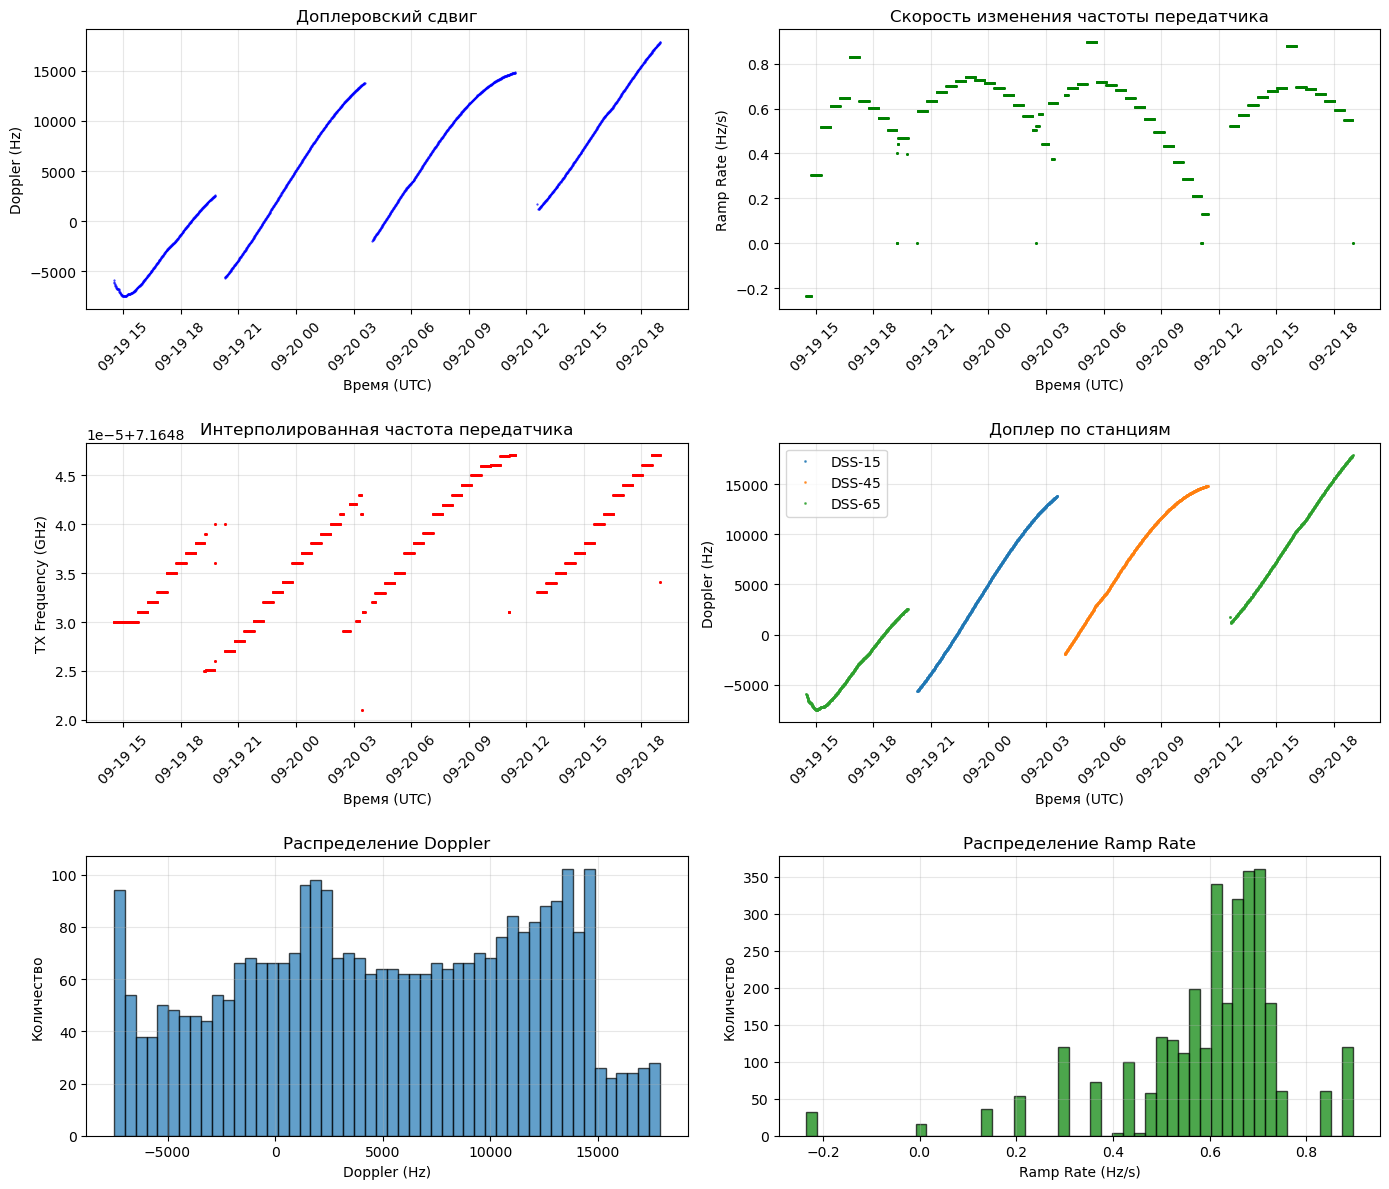

In [87]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# 1. Доплер во времени
ax = axes[0, 0]
ax. plot(df_result['datetime_utc'], df_result['doppler_hz'], 'b. ', markersize=1, alpha=0.5)
ax.set_xlabel('Время (UTC)')
ax.set_ylabel('Doppler (Hz)')
ax.set_title('Доплеровский сдвиг')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# 2. Ramp Rate во времени (из объединённых данных)
ax = axes[0, 1]
mask = df_result['ramp_rate_hz_s'].notna()
ax.plot(df_result. loc[mask, 'datetime_utc'], 
        df_result.loc[mask, 'ramp_rate_hz_s'], 'g. ', markersize=2)
ax.set_xlabel('Время (UTC)')
ax.set_ylabel('Ramp Rate (Hz/s)')
ax.set_title('Скорость изменения частоты передатчика')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# 3. Интерполированная частота передатчика
ax = axes[1, 0]
mask = df_result['interpolated_tx_freq_hz'].notna()
ax.plot(df_result.loc[mask, 'datetime_utc'], 
        df_result.loc[mask, 'interpolated_tx_freq_hz']/1e9, 'r.', markersize=2)
ax.set_xlabel('Время (UTC)')
ax.set_ylabel('TX Frequency (GHz)')
ax.set_title('Интерполированная частота передатчика')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3)

# 4. Доплер по станциям
ax = axes[1, 1]
for station in sorted(df_result['receiving_station_id'].unique()):
    mask = df_result['receiving_station_id'] == station
    ax. plot(df_result.loc[mask, 'datetime_utc'], 
            df_result.loc[mask, 'doppler_hz'], '. ', 
            markersize=2, label=f'DSS-{station}', alpha=0.7)
ax.set_xlabel('Время (UTC)')
ax.set_ylabel('Doppler (Hz)')
ax.set_title('Доплер по станциям')
ax.tick_params(axis='x', rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Гистограмма Doppler
ax = axes[2, 0]
ax. hist(df_result['doppler_hz'], bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Doppler (Hz)')
ax.set_ylabel('Количество')
ax.set_title('Распределение Doppler')
ax.grid(True, alpha=0.3)

# 6. Гистограмма Ramp Rate
ax = axes[2, 1]
mask = df_result['ramp_rate_hz_s'].notna()
ax.hist(df_result.loc[mask, 'ramp_rate_hz_s'], bins=50, edgecolor='black', alpha=0.7, color='green')
ax.set_xlabel('Ramp Rate (Hz/s)')
ax.set_ylabel('Количество')
ax.set_title('Распределение Ramp Rate')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('output_data/combined_analysis.png', dpi=150)
plt.show()

Очистка данных


🚀 ЗАПУСК ОЧИСТКИ ОБЪЕДИНЁННЫХ ДАННЫХ
 КОМПЛЕКСНАЯ ОЧИСТКА ДАННЫХ (DOPPLER + RAMP)

 ИТОГИ ОЧИСТКИ
   Исходных записей:      3,166
   Удалено (скачки):     4
   Удалено (скорость):   1,588
   Удалено (RAMP аном. ): 0
   ИТОГО удалено:        1,588
   Осталось записей:     1,578 (49.8%)
   Количество сеансов:   4

 Очищенные данные сохранены:  output_data/mgs_doppler_ramp_CLEANED.csv


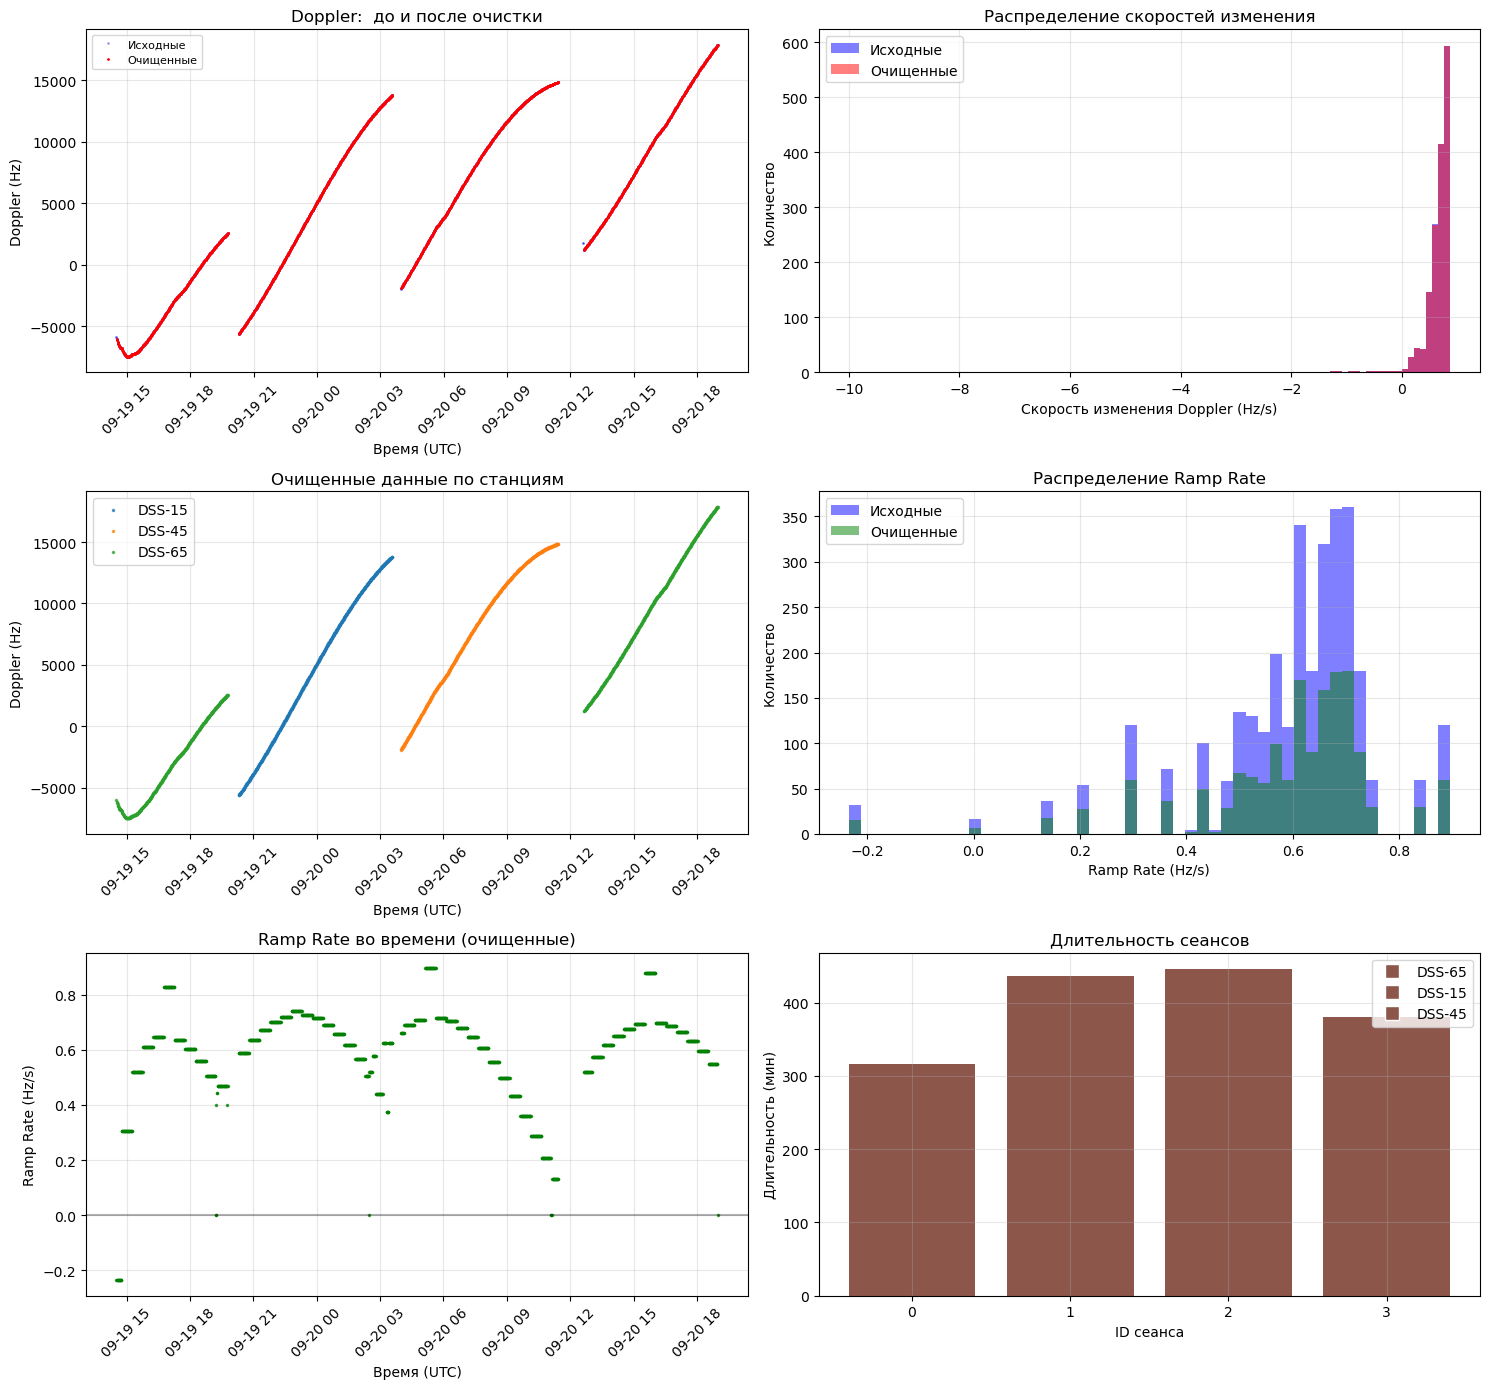


 График сохранён:  output_data/cleaning_report_with_ramp.png

 Первые 20 записей очищенных данных:


,datetime_utc,time_tag_seconds,doppler_hz,data_type_id,receiving_station_id,transmitting_station_id,ref_freq_mhz,source_file,lbl_file,ramp_rate_hz_s,ramp_start_freq_hz,interpolated_tx_freq_hz,ramp_time_offset_sec,session_id
2,1997-09-19 14:31:30,1.505831e+09,-6036.117110,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,901.0,0
4,1997-09-19 14:32:30,1.505832e+09,-6159.048813,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,961.0,0
6,1997-09-19 14:33:30,1.505832e+09,-6269.126380,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,1021.0,0
8,1997-09-19 14:34:30,1.505832e+09,-6368.019484,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,1081.0,0
11,1997-09-19 14:35:30,1.505832e+09,-6455.088767,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,1141.0,0
12,1997-09-19 14:36:30,1.505832e+09,-6531.223746,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,1201.0,0
14,1997-09-19 14:37:30,1.505832e+09,-6598.073058,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,1261.0,0
16,1997-09-19 14:38:30,1.505832e+09,-6654.208186,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,1321.0,0
18,1997-09-19 14:39:30,1.505832e+09,-6702.035289,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,1381.0,0
21,1997-09-19 14:40:30,1.505832e+09,-6740.114075,12,65,65,70205.932,7262262a.odf,7262262a.lbl,-0.234592,7.164830e+09,7.164830e+09,1441.0,0


In [89]:
# ============================================================
# КОМПЛЕКСНАЯ ОЧИСТКА ДАННЫХ (DOPPLER + RAMP)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta


def comprehensive_clean_with_ramp(df, 
                                   max_jump_hz=1000, 
                                   max_doppler_rate=3.0,
                                   max_ramp_rate=15.0,
                                   max_gap_min=5,
                                   require_ramp=True):
    """
    Комплексная очистка данных Doppler + RAMP без "прыгающих" значений.
    """
    print("="*60)
    print(" КОМПЛЕКСНАЯ ОЧИСТКА ДАННЫХ (DOPPLER + RAMP)")
    print("="*60)
    
    df_work = df.sort_values('datetime_utc').copy()
    original_count = len(df_work)
    
    removed_stats = {
        'original':  original_count,
        'doppler_jumps': 0,
        'doppler_rate':  0,
        'ramp_anomalies': 0,
        'no_ramp':  0,
        'total_removed': 0
    }
    
    # ==================== ТЕХНИЧЕСКИЕ КОЛОНКИ ====================
    df_work['time_diff_sec'] = df_work['datetime_utc'].diff().dt.total_seconds()
    df_work['doppler_diff'] = df_work['doppler_hz']. diff()
    df_work['doppler_rate'] = df_work['doppler_diff'] / df_work['time_diff_sec']
    
    # ==================== ФИЛЬТР 1: СКАЧКИ ДОПЛЕРА ====================
    mask_no_jumps = abs(df_work['doppler_diff']) <= max_jump_hz
    mask_no_jumps = mask_no_jumps.fillna(True)  # первая запись
    removed_stats['doppler_jumps'] = (~mask_no_jumps).sum()
    
    # ==================== ФИЛЬТР 2: СКОРОСТЬ ИЗМЕНЕНИЯ ====================
    mask_good_doppler_rate = abs(df_work['doppler_rate']) <= max_doppler_rate
    mask_good_doppler_rate = mask_good_doppler_rate.fillna(True)  # первая запись и разрывы
    removed_stats['doppler_rate'] = (~mask_good_doppler_rate).sum()
    
    # ==================== ФИЛЬТР 3: АНОМАЛЬНЫЕ RAMP ====================
    mask_good_ramp = pd.Series(True, index=df_work.index)
    if 'ramp_rate_hz_s' in df_work.columns:
        mask_good_ramp = (df_work['ramp_rate_hz_s'].abs() <= max_ramp_rate) | df_work['ramp_rate_hz_s'].isna()
    removed_stats['ramp_anomalies'] = (~mask_good_ramp & df_work['ramp_rate_hz_s'].notna()).sum()
    
    # ==================== ФИЛЬТР 4: ТРЕБОВАНИЕ RAMP ====================
    mask_has_ramp = pd.Series(True, index=df_work.index)
    if require_ramp and 'ramp_rate_hz_s' in df_work.columns:
        mask_has_ramp = df_work['ramp_rate_hz_s'].notna()
        removed_stats['no_ramp'] = (~mask_has_ramp).sum()
    
    # ==================== ПРИМЕНЯЕМ ВСЕ ФИЛЬТРЫ ====================
    final_mask = mask_no_jumps & mask_good_doppler_rate & mask_good_ramp & mask_has_ramp
    df_clean = df_work[final_mask].copy()
    
    # ==================== РАЗБИЕНИЕ НА СЕАНСЫ ====================
    df_clean['time_diff_sec'] = df_clean['datetime_utc'].diff().dt.total_seconds()
    time_gaps = df_clean['time_diff_sec'] > (max_gap_min * 60)
    df_clean['session_id'] = time_gaps.cumsum()
    
    # ==================== СТАТИСТИКА ====================
    removed_stats['total_removed'] = original_count - len(df_clean)
    removed_stats['final'] = len(df_clean)
    
    print(f"\n{'='*60}")
    print(" ИТОГИ ОЧИСТКИ")
    print("="*60)
    print(f"   Исходных записей:      {original_count:,}")
    print(f"   Удалено (скачки):     {removed_stats['doppler_jumps']:,}")
    print(f"   Удалено (скорость):   {removed_stats['doppler_rate']:,}")
    print(f"   Удалено (RAMP аном. ): {removed_stats['ramp_anomalies']:,}")
    if require_ramp: 
        print(f"   Удалено (без RAMP):   {removed_stats['no_ramp']:,}")
    print(f"   ИТОГО удалено:        {removed_stats['total_removed']:,}")
    print(f"   Осталось записей:     {len(df_clean):,} ({100*len(df_clean)/original_count:.1f}%)")
    print(f"   Количество сеансов:   {df_clean['session_id'].nunique()}")
    
    # ==================== УДАЛЕНИЕ ТЕХНИЧЕСКИХ КОЛОНОК ====================
    df_clean.drop(columns=['time_diff_sec','doppler_diff','doppler_rate'], errors='ignore', inplace=True)
    
    return df_clean, removed_stats


def plot_cleaning_results_with_ramp(original_df, cleaned_df, title_prefix="MGS"):
    """
    Визуализация результатов очистки с RAMP данными. 
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 14))
    
    # ==================== 1. ДО И ПОСЛЕ ====================
    ax = axes[0, 0]
    ax.plot(original_df['datetime_utc'], original_df['doppler_hz'], 
            'b. ', alpha=0.3, markersize=2, label='Исходные')
    ax.plot(cleaned_df['datetime_utc'], cleaned_df['doppler_hz'], 
            'r.', markersize=2, label='Очищенные')
    ax.set_xlabel('Время (UTC)')
    ax.set_ylabel('Doppler (Hz)')
    ax.set_title('Doppler:  до и после очистки')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # ==================== 2. СКОРОСТЬ ИЗМЕНЕНИЯ ====================
    ax = axes[0, 1]
    
    orig_sorted = original_df. sort_values('datetime_utc').copy()
    orig_sorted['rate'] = orig_sorted['doppler_hz']. diff() / orig_sorted['datetime_utc'].diff().dt.total_seconds()
    
    clean_sorted = cleaned_df.sort_values('datetime_utc').copy()
    clean_sorted['rate'] = clean_sorted['doppler_hz'].diff() / clean_sorted['datetime_utc'].diff().dt.total_seconds()
    
    ax.hist(orig_sorted['rate'].dropna().clip(-10, 10), bins=100, alpha=0.5, 
            label='Исходные', color='blue')
    ax.hist(clean_sorted['rate'].dropna().clip(-10, 10), bins=100, alpha=0.5, 
            label='Очищенные', color='red')
    ax.set_xlabel('Скорость изменения Doppler (Hz/s)')
    ax.set_ylabel('Количество')
    ax.set_title('Распределение скоростей изменения')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # ==================== 3. ПО СТАНЦИЯМ ====================
    ax = axes[1, 0]
    colors = plt.cm.tab10.colors
    for i, station in enumerate(sorted(cleaned_df['receiving_station_id'].unique())):
        mask = cleaned_df['receiving_station_id'] == station
        ax.plot(cleaned_df. loc[mask, 'datetime_utc'], 
                cleaned_df.loc[mask, 'doppler_hz'], 
                '. ', markersize=3, color=colors[i % len(colors)],
                label=f'DSS-{station}', alpha=0.7)
    ax.set_xlabel('Время (UTC)')
    ax.set_ylabel('Doppler (Hz)')
    ax.set_title('Очищенные данные по станциям')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # ==================== 4. RAMP RATE ====================
    ax = axes[1, 1]
    
    has_ramp_orig = original_df['ramp_rate_hz_s'].notna()
    has_ramp_clean = cleaned_df['ramp_rate_hz_s'].notna()
    
    if has_ramp_orig.any():
        ax.hist(original_df.loc[has_ramp_orig, 'ramp_rate_hz_s']. clip(-20, 20), 
                bins=50, alpha=0.5, label='Исходные', color='blue')
    if has_ramp_clean.any():
        ax.hist(cleaned_df.loc[has_ramp_clean, 'ramp_rate_hz_s']. clip(-20, 20), 
                bins=50, alpha=0.5, label='Очищенные', color='green')
    ax.set_xlabel('Ramp Rate (Hz/s)')
    ax.set_ylabel('Количество')
    ax.set_title('Распределение Ramp Rate')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # ==================== 5. RAMP RATE ВО ВРЕМЕНИ ====================
    ax = axes[2, 0]
    
    if has_ramp_clean.any():
        ax.plot(cleaned_df.loc[has_ramp_clean, 'datetime_utc'], 
                cleaned_df.loc[has_ramp_clean, 'ramp_rate_hz_s'], 
                'g.', markersize=3, alpha=0.7)
    ax.set_xlabel('Время (UTC)')
    ax.set_ylabel('Ramp Rate (Hz/s)')
    ax.set_title('Ramp Rate во времени (очищенные)')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # ==================== 6. СЕАНСЫ ====================
    ax = axes[2, 1]
    
    session_stats = []
    for session in cleaned_df['session_id'].unique():
        sess_data = cleaned_df[cleaned_df['session_id'] == session]
        duration = (sess_data['datetime_utc'].max() - sess_data['datetime_utc'].min()).total_seconds() / 60
        station = sess_data['receiving_station_id']. iloc[0]
        session_stats.append({
            'session':  int(session),
            'duration': duration,
            'count': len(sess_data),
            'station': station
        })
    
    if session_stats: 
        stats_df = pd.DataFrame(session_stats)
        colors_bar = [plt.cm.tab10.colors[s % 10] for s in stats_df['station']]
        bars = ax.bar(stats_df['session']. astype(str), stats_df['duration'], color=colors_bar)
        ax.set_xlabel('ID сеанса')
        ax.set_ylabel('Длительность (мин)')
        ax.set_title('Длительность сеансов')
        ax.grid(True, alpha=0.3)
        
        # Легенда для станций
        unique_stations = stats_df['station'].unique()
        legend_elements = [plt.Line2D([0], [0], marker='s', color='w', 
                          markerfacecolor=plt.cm.tab10.colors[s % 10], 
                          markersize=10, label=f'DSS-{s}') for s in unique_stations]
        ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.savefig('output_data/cleaning_report_with_ramp.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\n График сохранён:  output_data/cleaning_report_with_ramp.png")


# ============================================================
# ЗАПУСК ОЧИСТКИ
# ============================================================

print("\n" + "="*70)
print("🚀 ЗАПУСК ОЧИСТКИ ОБЪЕДИНЁННЫХ ДАННЫХ")
print("="*70)

# Очищаем данные
df_cleaned, stats = comprehensive_clean_with_ramp(
    df_result,
    max_jump_hz=1000,        # Максимальный скачок Doppler
    max_doppler_rate=3.0,    # Максимальная скорость изменения Doppler (Hz/s)
    max_ramp_rate=15.0,      # Максимальный |ramp_rate| (Hz/s)
    max_gap_min=5,           # Разрыв для нового сеанса (минуты)
    require_ramp=False       # True = удалить записи без RAMP
)

# Сохраняем
df_cleaned.to_csv('output_data/mgs_doppler_ramp_CLEANED.csv', index=False)
print(f"\n Очищенные данные сохранены:  output_data/mgs_doppler_ramp_CLEANED.csv")

# Визуализация
plot_cleaning_results_with_ramp(df_result, df_cleaned)

# Показываем результат
print("\n Первые 20 записей очищенных данных:")
display(df_cleaned.head(20))